# ENV/ATM 415: Climate Laboratory

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 9: Radiative-Convective Equilibrium

____________
<a id='section1'></a>

## 1. Summarize our pure Radiative Equilibrium results
____________

This section repeats calculations from the Radiative Equilibrium notes.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from metpy.plots import SkewT
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

In [2]:
#  Get the observed air temperature
# The NOAA ESRL server is shutdown! January 2019
#temperature_filename = 'air.mon.1981-2010.ltm.nc'  # temperature
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
#ncep_air = xr.open_dataset(ncep_url + temperature_filename, decode_times=False)
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/pressure/air'
air = xr.open_dataset(url)
# The name of the vertical axis is different than the NOAA ESRL version..
ncep_air = air.rename({'lev': 'level'})
#  Take global, annual average 
weight = np.cos(np.deg2rad(ncep_air.lat)) / np.cos(np.deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

In [3]:
#  Get the water vapor data
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))

In [4]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

Here we make four different single-column pure radiative models and compare their equilibrium temperature profiles.

In [5]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

rad = climlab.radiation.RRTMG(name='all gases',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
#  remove ozone
rad_noO3 = climlab.process_like(rad)
rad_noO3.absorber_vmr['O3'] *= 0.
rad_noO3.name = 'no O3'
#  remove water vapor
rad_noH2O = climlab.process_like(rad)
rad_noH2O.specific_humidity *= 0.
rad_noH2O.name = 'no H2O'
#  remove both
rad_noO3_noH2O = climlab.process_like(rad_noO3)
rad_noO3_noH2O.specific_humidity *= 0.
rad_noO3_noH2O.name = 'no O3, no H2O'
#  put all models together in a list
rad_models = [rad, rad_noO3, rad_noH2O, rad_noO3_noH2O]

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


Now we're going to loop through the list of models and integrate each one out to equilibrium!

In [6]:
for model in rad_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

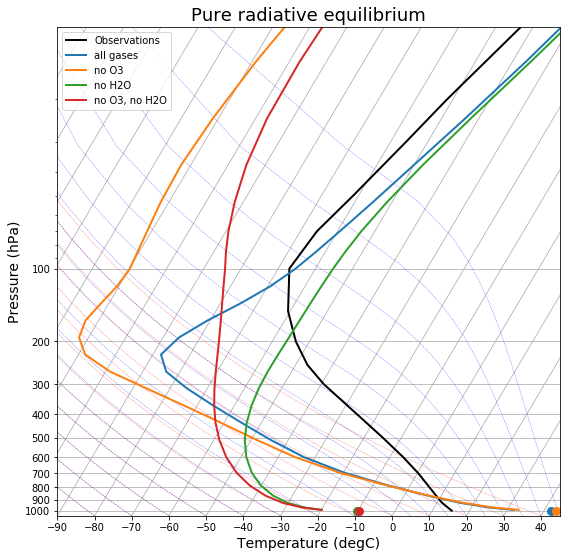

In [7]:
skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

As we have already discussed, none of these profiles really looks anything like the observations in the troposphere. This strongly suggests that other physical processes (aside from radiation) are important in determining the observed temperature profile.

Plotting on the skew-T diagram makes it clear that **all the radiative equilibrium profiles are statically unstable near the surface**.

So we're now going to **add a representation of the effects of convective mixing** to the single-column model.

____________
<a id='section2'></a>

## 2. A radiative-convective model: adjustment toward equilibrium
____________


To make a **Radiative-Convective model**, we just take a **radiation** model and couple it to a **convection** model!

The "convection" model we're going to use here is available as

```
climlab.convection.ConvectiveAdjustment
```

It is a simple process that looks for **lapse rates exceeding a critical threshold** and performs an **instantaneous adjustment** that mixes temperatures to the critical lapse rate while conserving energy.

This is a **parameterization** of the complex, rapid mixing processes that actually occur in an unstable air column!

Here is some code to put this model together in `climlab`:

In [8]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
rad = climlab.radiation.RRTMG(name='Radiation (net)',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=state,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,)
rcm = rad + conv
rcm.name = 'Radiative-Convective Model'

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [9]:
print(rcm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiative-Convective Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation (net): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



To get some insight into the interaction between radiation and convection, it's useful to look at the adjustment process from a non-equilibrium initial condition.

**Let's make an animation!**

The code below is complicated but it is mostly for generating the animation. Focus on the results, not the code here.

In [10]:
def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_atm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topname='Total', topdown=False):
        tendencies_atm[name] = proc.tendencies['Tatm'].to_xarray()
        tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
    for tend in [tendencies_atm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_atm, tendencies_sfc

def initial_figure(model):
    fig = plt.figure(figsize=(14,6))
    lines = []
    
    skew = SkewT(fig, subplot=(1,2,1), rotation=30)
    #  plot the observations
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')    
    lines.append(skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK, 
              linestyle='-', linewidth=2, color='C0', label='RC model (all gases)')[0])
    skew.ax.legend()
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-60, 75)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
                  markersize=8, color='C0', )[0])

    ax = fig.add_subplot(1,2,2, sharey=skew.ax)
    ax.set_ylim(1050, 10)
    ax.set_xlim(-8,8)
    ax.grid()
    ax.set_xlabel('Temperature tendency ($^\circ$C day$^{-1}$)', fontsize=14)

    color_cycle=['g','b','r','y','k']
    #color_cycle=['y', 'r', 'b', 'g', 'k']
    tendencies_atm, tendencies_sfc = get_tendencies(rcm)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines.append(ax.plot(tendencies_atm[name], model.lev, label=name, color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines.append(ax.plot(tendencies_sfc[name], 1000, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(skew.ax.text(-100, 50, 'Day {}'.format(int(model.time['days_elapsed'])), fontsize=12)) 
    return fig, lines

def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    lines[1].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    #lines[2].set_xdata(np.array(model.q)*1E3)
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines[2+i].set_xdata(tendencies_atm[name])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines[2+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines

We are going to start from an **isothermal** initial state, and let the model drift toward equilibrium.

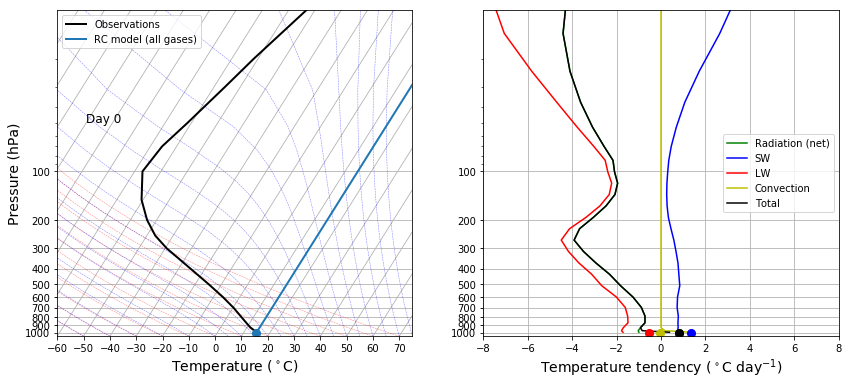

In [11]:
#  Start from isothermal state
rcm.state.Tatm[:] = rcm.state.Ts
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

Notice several things here:

- The initial profile is isothermal at 15ºC. This is an arbitrary choice we made.
- The initial tendency from **convection** is zero everywhere. Why?
- Shortwave radiation tends to **warm everywhere**. Why?
- Longwave radiation tends to **cool everywhere**. The cooling is very strong especially aloft. Why?
- The total tendency (black) is warming at the surface and cooling in the atmosphere. What should happen next? What are the implications for convective instability?

Now let's look at how the model actually adjusts:

In [12]:
#  This is where we make a loop over many timesteps and create an animation in the notebook
ani = animation.FuncAnimation(fig, animate, 150, fargs=(rcm, lines))
HTML(ani.to_html5_video())

Discuss.

### What if instead we start out from pure Radiative equilibrium?

This will represent the effect of a sudden "switching on" of convective processes.

In [13]:
#  Here we take JUST THE RADIATION COMPONENT of the full model and run it out to (near) equilibrium
#  This is just to get the initial condition for our animation
for n in range(1000):
    rcm.subprocess['Radiation (net)'].step_forward()

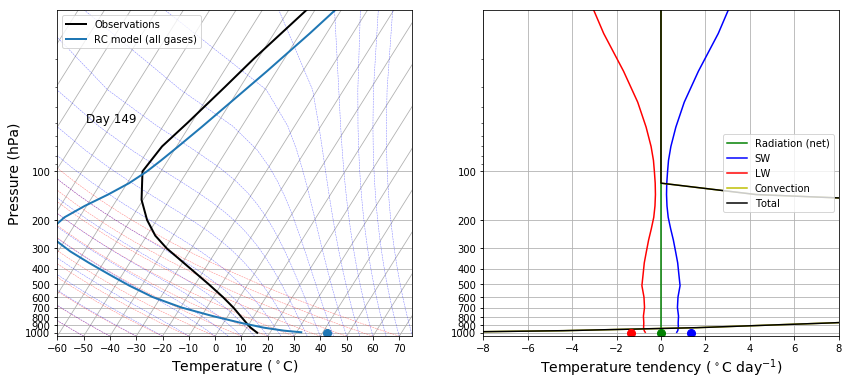

In [14]:
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

In [15]:
#  This is where we make a loop over many timesteps and create an animation in the notebook
ani = animation.FuncAnimation(fig, animate, 100, fargs=(rcm, lines))
HTML(ani.to_html5_video())

This animation is not as exciting because the **instability is destroyed immediately** in the first timestep!

That is because the `ConvectiveAdjustment` process operates instantaneously whenever there is any instability. It is a parameterization taking advantage of the fact that, in nature, **convection processes are fast compared to radiative processes**.

But notice that the final state is pretty much the same as in the first animation.

**The column tends toward the same equilibrium state regardless of where it starts.**

____________
<a id='section3'></a>

## 3. Compare Radiative- and Radiative-Convective Equilibrium
____________

Let's repeat our experiment with removing certain absorbing gases from the model, but use the Radiative-Convective model.

In [16]:
rc_models = []
for r in rad_models:
    newrad = climlab.process_like(r)
    conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=newrad.state,
                                               adj_lapse_rate=6.5,
                                               timestep=newrad.timestep,)
    rc = newrad + conv
    rc.name = newrad.name
    rc_models.append(rc)

for model in rc_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

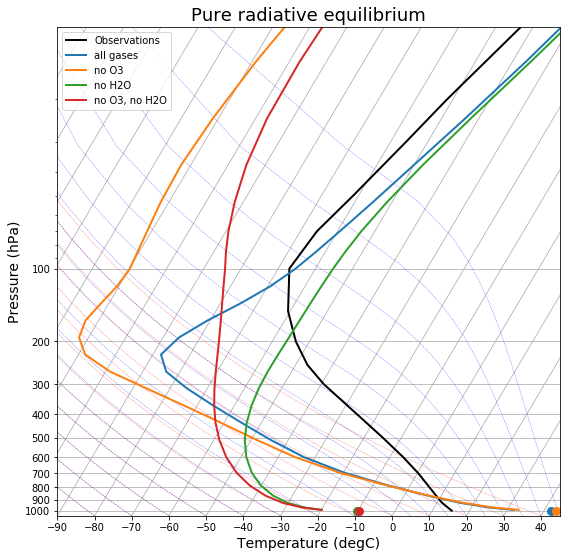

In [17]:
skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

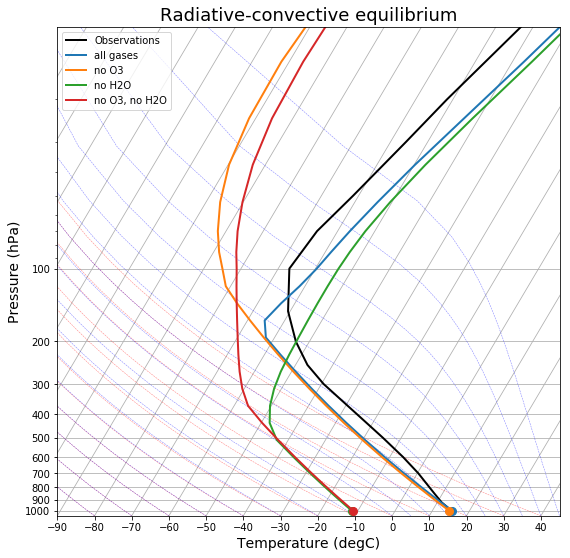

In [18]:
skew2 = make_skewT()
for model in rc_models:
    add_profile(skew2, model)
skew2.ax.set_title('Radiative-convective equilibrium', fontsize=18);

Lots to discuss here.

The overall message is that equilibrium temperature profile results from a competition between radiation and convection. Essentially:

- Radiation is always trying to push temperatures toward radiative equilibrium, which means
    - warm surface
    - cold troposphere
- Convection cools the surface and warms the troposphere
- The troposphere can be defined here as the layer over which convection is active.
- This is true whether or not we have the radiative effects of water vapor.
- When we remove the water vapor (and its warming greenhouse effect), the surface temperature becomes much colder and the troposphere is much shallower -- but it is still there.

____________
<a id='section4'></a>

## 4. The role of the critical lapse rate
____________

These calculations all used a critical lapse rate of 6.5 K / km, which is a reasonable approximation to observations.

We set this with the input argument
```
adj_lapse_rate
```
to the `ConvectiveAdjustment` process.

The idea is that we are trying to represent the statistical effects of many episodes of moist convection.

An air column that is perfectly neutral to moist instability would follow the blue **moist adiabats** on the skew-T diagrams.

However the real atmosphere, on average, does not exactly follow these adiabats for several reasons:

- the atmosphere is not perfectly saturated with water vapor
- the slope of the moist adiabat depends strongly on temperature (as we can see on these diagrams)
- We are looking at temperatures averaged over the whole planet, including regions that are warm and moist, warm and dry, and cold.

So here we sweep all this complexity under the rug and just choose a single critical lapse rate for our convective adjustment model.

But this is a **parameter** that is uncertain and could be interesting to explore.

### Python exercise

Repeat the whole series of calculations for the different combinations of absorbing gases above, but with different critical lapse rates:

- 9.8 K / km (the dry adiabatic lapse rate, suitable for an atmosphere where condensation does not impact the buoyancy of air parcels)
- 5 K / km (perhaps suitable for a very warm and moist atmosphere)